# Session 8 - Source model calibration using PEST and Veneer

PEST is a highly capable system for model calibration, and for sensitivity and uncertainty analysis. PEST is independent of any particular modelling software and modellers have connected Source to PEST in a number of ways.

This tutorial looks at specific support in veneer-py for calibration Source models with PEST. Notably, you can describe the PEST job in the notebook and veneer-py will generate the required PEST configuration files.

At the time of writing, this functionality supports basic calibration of model parameters to timeseries observations.

## Get PEST

PEST can be downloaded from [http://www.pesthomepage.org/](http://www.pesthomepage.org/). You want the standard PC PEST for Windows - *not BEOPEST*. PEST is delivered as a zip file - unzip to a directory on your system (ideally a directory without spaces or special characters in the path - something like `C:\PEST` is good)

This tutorial will gloss over a lot of PEST specifics in order to focus on the connection to Source and Veneer. The PEST manual is very comprehensive and it is available from the PEST homepage and included with the software.


## Overview

- How will it work?
- Describing the PEST ‘job'
  - Veneer/Source end-point(s)
  - Getting the model ‘ready’ for optimisation
  - Describing the calibration parameters
  - Describing the objective and any observed data
  - What veneer-py is taking care of
- Running PEST, feedback
- Limitations

## Which Model?

**Note:** This session uses `ExampleProject/CalibrationExample.rsproj`. You are welcome to work with your own model instead, however you will need to change the notebook text at certain points to reflect the names of nodes, links and functions in your model file.


## How will it work?

PEST requires a series of configuration file that describe the parameter estimation problem, including:

* What program to run and what command line arguments to use
* A description of one or more text files that PEST can modify in order to create a unique run of the model
* Description of one or more results text files that PEST can read to interpret the results of the model run
* Optional files that control parallel processing by running multiple copies of the model in parallel.

veneer-py has functionality for describing the calibration problem in Python, and then subsequently generating the files expected by PEST. This includes generating a Python script, which becomes the program that PEST invokes. This Python program calls to a running copy of Veneer to execute the Source model and retrieve results.

When running PEST in parallel, PEST controls a number of 'slave' processes, each of which is responsible for running one copy of the simulation at a time:

![Running PEST on a Source model from Python](Images/Tutorials/Veneer_PEST.png)

In this way, you can run a PEST calibration for a Source model that is running in the main Source windows application. You can start multiple copies of Source in order to support parallel calibrations. Alternatively, you can use the Veneer Command Line tool.

### Setting up the servers

As in Tutorial 7, we'll use the command line and set up a number of copies of the server using the `start()` function

In [1]:
from veneer.manage import start, create_command_line, kill_all_now
import veneer

In [2]:
veneer_install = 'D:\\src\\projects\\Veneer\\Compiled\\Source 4.1.1.4484 (public version)'
source_version = '4.1.1'
cmd_directory = 'E:\\temp\\veneer_cmd'
path = create_command_line(veneer_install,source_version,dest=cmd_directory)
path

'E:\\temp\\veneer_cmd\\FlowMatters.Source.VeneerCmd.exe'

In [3]:
catchment_project='ExampleProject/CalibrationExample.rsproj'
num_copies=20    # Important - set this to be a number ~ the number of CPU cores in your system!
first_port=9950

In [4]:
processes,ports = start(catchment_project,
                        n_instances=num_copies,
                        ports=first_port,
                        debug=True,
                        veneer_exe=path,
                        remote=False)

Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9950 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9951 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9952 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9953 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9954 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9955 -s  "D:\src\projects\veneer-py\doc\training\ExampleProject\CalibrationExample.rsproj"
Starting E:\temp\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9956 -

Also as before, we need a copy of the Veneer client for each copy of the server:

In [5]:
vs = [veneer.Veneer(port=p) for p in ports]

### The catchment

We haven't used this project in the earlier tutorials. We can query any of the servers for the network (just as we would if Veneer were running within the Source application)

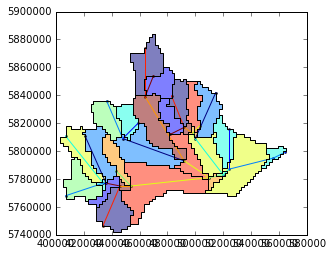

In [6]:
%matplotlib inline
v = vs[0]
v.network().as_dataframe().plot()

## Describing the PEST 'Job'

When configuring PEST to work with a particular model, you 'teach' PEST how to communicate with the model by describing the format of one or more text input files expected by the model and one or more text output files produced by the model. PEST will then generate updated input files for each simulation and read the updated output files that result from the simulation.

veneer-py has some basic functionality for setting up PEST runs that avoids the need to directly edit the PEST configuration files.

With veneer-py, you can describe a PEST job in Python, including describing the Source model parameters that you want to calibrate and the outputs that you want to calibrate against.

veneer-py will then write out the following PEST configuration files and invoke PEST:

* **PTF:** A PEST Template File, which describes how to run the model, including setting relevant model parameters and ensuring that the required model outputs are produced. PEST will substitute model parameters into this file, based on the configuration in the PCF. In the case of veneer-py, the PTF is a template of a Python script, which uses veneer-py to connect to a Source/Veneer server, sets parameters, runs the model and then compares results using defined statistics.
* **PIF:** A PEST Instruction File, which tells PEST where to find the observations that it needs for evaluating a simulation. In the case of veneer-py, these outputs are produced by the logic in the PTF.
* **PCF:** A PEST Control File, which desribes the parameters to be optimised and the observations to optimise to, as well as how to run the model.
* **PRF:** (OPTIONAL), used when performing a parallel calibration with more than one Veneer/Source server. Describes where (on the filesystem) to run the model from.

To establish all these files and run a PEST job, you can use functionality in veneer-py to describe a PEST 'Case'.

The 'Case' will ultimately know everything about the calibration

* what parameters you are calibrating and how they are constrained,
* what you are calibrating to,
* how many Source servers you have at your disposal
* any options related to PEST, such as which optimisation routine to use

In [13]:
from veneer.pest import Case

At very least, we need to give a Case a `name` - which is the basis for all the filenames that will be written out.

You can also specify:

* an optimiser (the default is `pest`, but the PEST software also comes several others)
* a list of Veneer/Source servers, described as a list of ports
* a random number seed in order to either make the optimisation deterministic or allow random variation


In [15]:
calibration = Case('CalibrationCase',optimiser='cmaes_p',model_servers=ports)

PEST has many options - most of which we leave at default. One option that we currently need is to put PEST into single precision mode. This is because PEST, in double precision mode, uses a syntax for floating point literals that is not valid Python:

In [16]:
calibration.options['PRECIS']='single' 

### Configuring the calibration parameters

PEST needs to be told about the calibration parameters

This is a two step process:
* Specify how to apply the parameter (using a statement as you would in Veneer. eg `model.catchment.runoff.set_param_values('baseflowCoefficient',0.5,fus=list(fu_types))` but with the actual value (`0.5`) changed to the PEST parameter name, with markers (eg `@v_bfCoeff@`). This information forms part of a dynamically generated Python script that PEST will modify and run for each simulation
* Tell PEST about the parameter, including its range.
  * This forms part of the PEST control file
  * In addition to the range, we also specify the initial value.
  * We set the initial value to be halfway between the min and max

We're performing a rainfall runoff calibration, with the four parameter GR4J rainfall runoff used in the model

We're going to perform a lumped calibration - ie one parameter set everywhere - but we could, alternatively, calibrate distinct parameters by functional unit type, or in different parts of the catchment.

In [17]:
v.model.find_model_type('GR4J')

['TIME.Models.RainfallRunoff.GR4J.GR4J']

In [18]:
params = v.model.find_parameters('TIME.Models.RainfallRunoff.GR4J.GR4J')
params

['C', 'k', 'x1', 'x2', 'x3', 'x4']

We only want to calibrate `x1`-`x4` - (`C` and `k` are specific to the eWater version of GR4J - they provide a baseflow filter)

In [19]:
params = params[2:]
params

['x1', 'x2', 'x3', 'x4']

We need to assign ranges to each of these. The model implementation in Source has metadata about suitable ranges - but at this stage, there isn't an easy way to interrogate that information from veneer-py. You can check in the Source user interface (`Edit|Rainfall Runoff Models`) to see the ranges.

Having done that, we'll construct a Python dictionary of parameter ranges

**Note:** These are quite narrow ranges for GR4J. This is done to keep the optimisation short in the context of the tutorial (and because the 'observed' data is actually synthetic data generated from Source)

In [20]:
ranges = {
    'x1':[100.0,500.0],
    'x2':[1.0,5.0],
    'x3':[1.0,200.0],
    'x4':[0.5,3.0]
}
ranges

{'x1': [100.0, 500.0], 'x2': [1.0, 5.0], 'x3': [1.0, 200.0], 'x4': [0.5, 3.0]}

Now, we can loop over each parameter and 'teach' PEST about it - ie tell PEST how to modify the parameter and tell PEST what range we want to calibrate over:

In [21]:
for param,param_range in ranges.items():
    print('Configuring %s'%param)

    pest_pname = '$'+param+'$'

    # 1. Tell PEST how to set the parameter
    calibration.parameters.model.catchment.runoff.set_param_values(param,pest_pname)

    # 2. Details of the PEST parameter. name, starting value, min, max

    # Decide what to use for the initial value... half way between min and max!
    initial = 0.5*(param_range[0]+param_range[1])
    
    calibration.parameters.describe(pest_pname,initial,param_range[0],param_range[1])

Configuring x1
Configuring x2
Configuring x4
Configuring x3


**Note:** When we tell PEST how to set the parameter in the model, we use a Python statement that looks similar to statements from earlier sessions:
```python
calibration.parameters.model.catchment.runoff.set_param_values(param,pest_pname)
# is similar to
v.model.catchment.runoff.set_param_values(param,value)
```
The instructions to PEST will in fact translate to instructions to a Veneer client (`v`). So everything after `.parameter.` should be something you can call on a Veneer client. The other main difference is that, instead of passing in an actual value at this point, you pass `pest_pname`, which will be something like `$x1$` and will get translated to an actual value at runtime.


The previous code has gone some way towards configuring the PEST job. We can get a preview of what has been achieved by asking to see the configuration as it stands.

First, the state of the PTF (PEST Template File). You can see that it looks very much like a Python script, except where it has references to things like `$x1$` and the like

In [22]:
print(calibration.ptf_text())

ptf $
from veneer.pest_runtime import *
from veneer import Veneer
from veneer.stats import * 
import pandas as pd
from veneer import general

general.PRINT_URLS=False
veneer_port=find_port()
v = Veneer(port=veneer_port)
v.model.catchment.runoff.set_param_values('x1',$x1$)
v.model.catchment.runoff.set_param_values('x2',$x2$)
v.model.catchment.runoff.set_param_values('x4',$x4$)
v.model.catchment.runoff.set_param_values('x3',$x3$)
# Run Model
v.drop_all_runs()
v.run_model(**{})

observed_ts={}
pest_observations=[]

# Get results
run_results = v.retrieve_run()

# Compute stats



# Write summary results
print(pest_observations)
write_outputs(pest_observations,'_CalibrationCase_output.txt')
write_outputs(pest_observations,'__outputs_to_keep.txt')



There are still gaps in the PTF - eg the `# Compute Stats` section - that will come as we describe the outputs and observations.

The PCF (PEST Control File) is also partly complete:

In [23]:
print(calibration.pcf_text())

pcf
* control data
restart estimation
4 0 1 0 1  
1 1 single point    
10.0 2.0 0.3 0.03 8   
10.0 10.0 0.001   
0.1     
50 0.005 4 4 0.005 4   
1 1 1       
* singular value decomposition
1
4 5e-07
0
* parameter groups
default_pg relative 0.001 0.0001 switch 1.5 parabolic   
* parameter data
x1 none factor 300.0 100.0 500.0 default_pg 1.0 0.0 1
x2 none factor 3.0 1.0 5.0 default_pg 1.0 0.0 1
x4 none factor 1.75 0.5 3.0 default_pg 1.0 0.0 1
x3 none factor 100.5 1.0 200.0 default_pg 1.0 0.0 1 
* observation groups
default_og  
* observation data

* model command line
python _run_CalibrationCase.py
* model input/output
_run_CalibrationCase.tpl _run_CalibrationCase.py
_CalibrationCase_output.ins _CalibrationCase_output.txt



**Note:** There are a lot of options in the PCF - and we are using defaults. They are very well described in the PEST Manual and can be specified using `calibration.options`

In [24]:
calibration.options

OrderedDict([('NPAR', None), ('NOBS', None), ('NPARGP', 1), ('NPRIOR', 0), ('NOBSGP', 1), ('MAXCOMPDIM', ''), ('DERZEROLIM', ''), ('NTPLFLE', None), ('NINSFLE', None), ('PRECIS', 'single'), ('DPOINT', 'point'), ('NUMCOM', ''), ('JACFILE', ''), ('MESSFILE', ''), ('OBSREREF', ''), ('RLAMBDA1', 10.0), ('RLAMFAC', 2.0), ('PHIRATSUF', 0.3), ('PHIREDLAM', 0.03), ('NUMLAM', 8), ('JACUPDATE', ''), ('LAMFORGIVE', ''), ('DERFORGIVE', ''), ('RELPARMAX', 10.0), ('FACPARMAX', 10.0), ('FACORIG', 0.001), ('IBOUNDSTICK', ''), ('UPVECBEND', ''), ('ABSPARMAX', ''), ('PHIREDSWH', 0.1), ('NOPTSWITCH', ''), ('SPLITSWH', ''), ('DOAUI', ''), ('DOSENREUSE', ''), ('BOUNDSCALE', ''), ('NOPTMAX', 50), ('PHIREDSTP', 0.005), ('NPHISTP', 4), ('NPHINORED', 4), ('RELPARSTP', 0.005), ('NRELPAR', 4), ('PHISTOPTHRESH', ''), ('LASTRUN', ''), ('PHIABANDON', ''), ('ICOV', 1), ('ICOR', 1), ('IEIG', 1), ('IRES', ''), ('JCOSAVE', ''), ('VERBOSEREC', ''), ('JCOSAVEITN', ''), ('REISAVEITN', ''), ('PARSAVEITN', ''), ('PARSAVERUN

### Configuring the outputs and observations

PEST needs to know what its calibrating to. In our case, that means a time series of observed data, and a corresponding modelled time series. We also need the objective function and the time period for the calibration.

PEST has a tool for processing time series data (TSPROC) but we don't use it here. Rather, we compute the objective values in Python and just pass single numbers back to PEST.

We'll start by loading the observed flow time series data into this notebook and exploring the data a bit...

**Note**: Loading the data at this point serves two purposes:
1. We become more familiar with the data and can identify things like the time period we want to calibrate over, and
2. We work out the exact `pandas` command needed to load the data. We need to give this command to PEST later on to call as part of the simulations...

In [26]:
import pandas as pd
flows = pd.read_csv('SyntheticObservedFlow.csv',parse_dates=True,dayfirst=True,index_col=0)
flows[0::50] # Show every fifty days

,Flow
Date,
2007-01-01,0.000000e+00
2007-02-20,1.103490e+00
2007-04-11,1.305575e+03
2007-05-31,3.417483e+03
2007-07-20,1.441880e+04
2007-09-08,1.650685e+05
2007-10-28,7.711668e+06
2007-12-17,3.111951e+06
2008-02-05,2.460641e+06


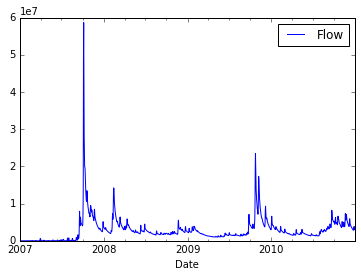

In [27]:
flows.plot()

**Note:** If your observed data had gaps during your simulation period, this would be a good point to establish the overlapping period in order to inform the simulation/calibration dates.

In our case, the data aligns with the simulation, so the simulation dates we want are just the start and end of the time series:

In [28]:
start,end = flows.index[[0,-1]]
start,end

(Timestamp('2007-01-01 00:00:00'), Timestamp('2010-12-31 00:00:00'))

This (synthetic) observed flow sequence relates to the (synthetic) gauge towards the bottom of the system. What was it called?

In [29]:
network = v.network()
nodes = network['features'].find_by_feature_type('node')
nodes._all_values('name')

['G123456A',
 'Generated node name #1',
 'Generated node name #2',
 'Generated node name #3',
 'Generated node name #4',
 'Generated node name #5',
 'Generated node name #6',
 'Generated node name #7',
 'Generated node name #8',
 'Generated node name #9',
 'Generated node name #10',
 'Generated node name #11',
 'Generated node name #12',
 'Generated node name #13',
 'Generated node name #14',
 'Generated node name #15',
 'Generated node name #16',
 'Generated node name #17',
 'Generated node name #18',
 'Generated node name #19',
 'Generated node name #20',
 'Generated node name #21',
 'Generated node name #22',
 'Generated node name #23',
 'Generated node name #24',
 'Generated node name #25',
 'Generated node name #26',
 'Generated node name #27',
 'Generated node name #28']

Aaah, we want `'G123456A'`

In [30]:
calibration_node = 'G123456A'

Now we can tell PEST about the observations and the comparison we want.

We need to tell PEST how to load the observed data - and the pandas command we used to do a test load will help:

```python
pd.read_csv('SyntheticObservedFlow.csv',parse_dates=True,dayfirst=True,index_col=0)
# will become
calibration.observations.data.read_csv('SyntheticObservedFlow.csv',parse_dates=True,dayfirst=True,index_col=0)
```


In [31]:
calibration.observations.data.read_csv('SyntheticObservedFlow.csv',parse_dates=True,dayfirst=True,index_col=0)

And we can set up the comparison

In [32]:
comparison={'NetworkElement':calibration_node,'RecordingVariable':'Downstream Flow Volume'}

veneer-py configures the observation based on the column name in the observed flow file (so that you can have multiple comparisons from different columns and files)

In [33]:
flows.columns

Index(['Flow'], dtype='object')

We also need to reference a stats function. You can write your own (but you'll need to store it in a `.py` file) or you can access one from `veneer.stats`

In [34]:
from veneer import stats

In [35]:
dir(stats)

['PBIAS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'intersect',
 'ioad',
 'nse',
 'ppmc',
 'rae',
 'rsr']

In [36]:
help(stats.nse)

Help on function nse in module veneer.stats:

nse(obs, pred)
    Nash-Sutcliffe Efficiency



In [37]:
calibration.observations.compare('Flow',comparison,stat=stats.nse,aggregation='daily')

We need to do one more thing: We need to make sure that each of our _n_ servers is configured to record the output we require.

We'll need to loop over each of our veneer clients and configure recording. We have `comparison` which describes what we want to record. We can disable all other outputs

In [38]:
for v in vs:
    veneer.log('Configuring recording for server on port %d'%v.port)
    v.configure_recording(enable=[comparison],disable=[{}])

Configuring recording for server on port 9950
Configuring recording for server on port 9951
Configuring recording for server on port 9952
Configuring recording for server on port 9953
Configuring recording for server on port 9954
Configuring recording for server on port 9955
Configuring recording for server on port 9956
Configuring recording for server on port 9957
Configuring recording for server on port 9958
Configuring recording for server on port 9959
Configuring recording for server on port 9960
Configuring recording for server on port 9961
Configuring recording for server on port 9962
Configuring recording for server on port 9963
Configuring recording for server on port 9964
Configuring recording for server on port 9965
Configuring recording for server on port 9966
Configuring recording for server on port 9967
Configuring recording for server on port 9968
Configuring recording for server on port 9969


If we look at the content of the PEST config files now, we'll see more details filled in:

In [39]:
print(calibration.ptf_text())

ptf $
from veneer.pest_runtime import *
from veneer import Veneer
from veneer.stats import * 
import pandas as pd
from veneer import general

general.PRINT_URLS=False
veneer_port=find_port()
v = Veneer(port=veneer_port)
v.model.catchment.runoff.set_param_values('x1',$x1$)
v.model.catchment.runoff.set_param_values('x2',$x2$)
v.model.catchment.runoff.set_param_values('x4',$x4$)
v.model.catchment.runoff.set_param_values('x3',$x3$)
# Run Model
v.drop_all_runs()
v.run_model(**{})

observed_ts={}
pest_observations=[]

# Get results
run_results = v.retrieve_run()

# Compute stats
observed_ts.update(pd.read_csv('SyntheticObservedFlow.csv',index_col=0,parse_dates=True,dayfirst=True).dropna(how='all').to_dict('series'))
mod_ts = v.retrieve_multiple_time_series(run_data=run_results,criteria={'NetworkElement': 'G123456A', 'RecordingVariable': 'Downstream Flow Volume'},timestep="daily")
print(mod_ts.columns)
assert(len(mod_ts.columns==0))
mod_ts = mod_ts[mod_ts.columns[0]]
obs_ts = observed_ts["Flo

In [40]:
print(calibration.pif_text())

pif $
$Flow$ !Flow!


In [41]:
print(calibration.pcf_text())

pcf
* control data
restart estimation
4 1 1 0 1  
1 1 single point    
10.0 2.0 0.3 0.03 8   
10.0 10.0 0.001   
0.1     
50 0.005 4 4 0.005 4   
1 1 1       
* singular value decomposition
1
4 5e-07
0
* parameter groups
default_pg relative 0.001 0.0001 switch 1.5 parabolic   
* parameter data
x1 none factor 300.0 100.0 500.0 default_pg 1.0 0.0 1
x2 none factor 3.0 1.0 5.0 default_pg 1.0 0.0 1
x4 none factor 1.75 0.5 3.0 default_pg 1.0 0.0 1
x3 none factor 100.5 1.0 200.0 default_pg 1.0 0.0 1 
* observation groups
default_og  
* observation data
Flow 0 1.0 default_og
* model command line
python _run_CalibrationCase.py
* model input/output
_run_CalibrationCase.tpl _run_CalibrationCase.py
_CalibrationCase_output.ins _CalibrationCase_output.txt



In [42]:
print(calibration.prf_text())

prf
20 0 0.5 1 0 run_slow_fac=1.5
Slave_9950 .\Slave_9950\
Slave_9951 .\Slave_9951\
Slave_9952 .\Slave_9952\
Slave_9953 .\Slave_9953\
Slave_9954 .\Slave_9954\
Slave_9955 .\Slave_9955\
Slave_9956 .\Slave_9956\
Slave_9957 .\Slave_9957\
Slave_9958 .\Slave_9958\
Slave_9959 .\Slave_9959\
Slave_9960 .\Slave_9960\
Slave_9961 .\Slave_9961\
Slave_9962 .\Slave_9962\
Slave_9963 .\Slave_9963\
Slave_9964 .\Slave_9964\
Slave_9965 .\Slave_9965\
Slave_9966 .\Slave_9966\
Slave_9967 .\Slave_9967\
Slave_9968 .\Slave_9968\
Slave_9969 .\Slave_9969\
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0



## Running PEST

We can now invoke the PEST run.

When you call `calibration.run()`, PEST will start, and, in this case, it will start parallel PEST mode with _n_ workers. However all output of PEST will be in files, and in the command prompt window from which you started the Jupyter notebook. You will need to look in these places for progress of the calibration.

When PEST finishes, you'll get the calibrated parameters back as well as details of the PEST run. The PEST manual covers the outputs of a PEST run in much detail

**Note:** PEST needs to be in your Windows path. If its not, the `run()` command won't work. You can temporarily add PEST to your path from within the notebook:



In [43]:
pest_path='C:\\PEST'
import os
os.environ['PATH'] = os.environ['PATH']+';'+pest_path

In [44]:
results = calibration.run()

In [45]:
#results = calibration.get_results()
results['parameters']

,offset,scale,value
parameter,,,
x1,0.0,1.0,400.128906
x2,0.0,1.0,1.198749
x4,0.0,1.0,2.199333
x3,0.0,1.0,54.981930


In [46]:
kill_all_now(processes)

## While you're waiting...

Now would be a good time to start sketching out an exercise of your own to tackle with veneer-py!